# Purpose

Create a larger training set of ~30,000 images:
1. Balance classes better
2. Prioritize images with fewer tags

In [100]:
%matplotlib inline

import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt

Load in training image details

In [113]:
with open('data/iMaterialist/train.json') as f:
    j = json.load(f)
    urls = pd.DataFrame(j['images'])
    labels = pd.DataFrame(j['annotations'])

print('URLs df\n------')
display(urls.head())

print('\nLabels df\n------')
display(labels.head())

URLs df
------


,imageId,url
0,1,https://contestimg.wish.com/api/webimage/570f3...
1,2,https://contestimg.wish.com/api/webimage/5468f...
2,3,https://contestimg.wish.com/api/webimage/54641...
3,4,https://contestimg.wish.com/api/webimage/550b9...
4,5,https://contestimg.wish.com/api/webimage/54451...



Labels df
------


,imageId,labelId
0,1,"[95, 66, 137, 70, 20]"
1,2,"[36, 66, 44, 214, 105, 133]"
2,3,"[170, 66, 97, 153, 105, 138]"
3,4,"[18, 66, 44, 153, 164]"
4,5,"[189, 66, 176, 137, 153, 74, 181, 171, 138]"


In [72]:
def stack_labels(df):
    stacked = df['labelId'].apply(pd.Series)
    stacked['image_id'] = df['imageId'].values
    stacked['label_count'] = df['labelId'].apply(len).values
    stacked = stacked.melt(id_vars=['image_id', 'label_count'],
                           value_name='label')
    stacked = stacked.drop('variable', axis=1).dropna()
    stacked['label'] = stacked['label'].astype(int)
    stacked = stacked.sort_values(by=['image_id', 'label'])
    stacked = stacked.reset_index(drop=True)
    return stacked

In [74]:
%%time
stacked = stack_labels(labels)

CPU times: user 4min, sys: 6.09 s, total: 4min 6s
Wall time: 3min 48s


In [114]:
display(stacked.head())
print('Stacked df shape: {:,}, {}'.format(*stacked.shape))

,image_id,label_count,label
0,1,5,20
1,1,5,66
2,1,5,70
3,1,5,95
4,1,5,137


Stacked df shape: 5,921,854, 3


In [118]:
vc = stacked.label.value_counts()
print('Top 5 labels\n---------')
display(vc[:5])

print('\n\n\nBottom 5 labels\n---------')
display(vc[-5:])

Top 5 labels
---------


66     743250
105    330864
153    261844
17     251869
171    243038
Name: label, dtype: int64




Bottom 5 labels
---------


84     52
162    52
145    41
16     23
163     7
Name: label, dtype: int64

# Extract images to use for training

Extract ~30,000 images with following conditions:
1. Each label has similar number of images associated with it
2. Utilize images with the fewest possible labels as priorty
3. use ~30,000 images total

Number of Images for Training: 33,048


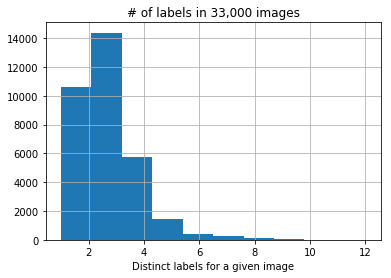

In [120]:
t = stacked.sort_values('label_count').groupby('label').head(150)
print('Number of Images for Training: {:,}'.format(t.shape[0]))

t.label_count.hist()
plt.title('# of labels in 33,000 images')
plt.xlabel('Distinct labels for a given image')
plt.show()

In [124]:
vc = t.label.value_counts()
print('Top 5 labels\n---------')
display(vc[:5])

print('\n\n\nBottom 15 labels\n---------')
display(vc[-15:])

Top 5 labels
---------


223    150
201    150
139    150
75     150
43     150
Name: label, dtype: int64




Bottom 15 labels
---------


148    150
214    150
215     99
161     98
1       79
156     73
46      71
86      69
41      68
107     66
84      52
162     52
145     41
16      23
163      7
Name: label, dtype: int64

# Assemble list of urls to download

In [129]:
unique_images = t.image_id.unique()

In [188]:
csv = labels.loc[labels['imageId'].isin(unique_images), :]
csv['label'] = csv['labelId'].str.join(' ').values
csv = csv.drop('labelId', axis=1)
csv.columns = ['id', 'label']

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [192]:
csv.to_csv('data/iMaterialist/train_30k_labels.csv', index=False)